Experiment Code Created with the help of Open AI's Chat GPT Language model!

In [ ]:
import torch as th
import torch
import torch.optim as optim
import torch.nn as nn

class AdaHessian(optim.Optimizer):
    def __init__(self,params, lr=.001, wd = 0, betas=(.9,.999),mc_iters=1, eps = 1e-8, control_variate=True):
        """Implements a modified version of the Ada Hessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"

        args:
            params (iterable): iterable of parameters

            lr (float, optional): the step size during gradient descent
            wd (float, optional): the weight decay hyperparemeter, using an L2 penalty.
            betas (tuple, optional): the momentum hyperparameters for the EMA of the gradient and hessian diagonal
            mc_iters (int, optional): the number of monte carlo iterations used to compute hutchinsons method.
            eps (float, optional): a factor added to the diagonal hessian to prevent division by too small a number.
            control_variate (bool, optional): a flag for wether the control_variate method is used or not.

        """
        super(AdaHessian, self).__init__(params, defaults={'lr':lr})
        self.state = dict()
        self.lr = lr
        self.betas = betas
        self.control_variate = control_variate
        self.eps = eps
        self.mc_iters = mc_iters
        self.n_steps = 0
        self.wd = wd
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(mom=th.zeros_like(p.data),hess_mom=th.zeros_like(p.data))
                p.hess = th.zeros_like(p.data)
    def zero_hessian(self):
        for group in self.param_groups:
            for p in group['params']:
                p.hess = th.zeros_like(p.data)

    def set_hessian(self):
        vals = []
        params = []
        if self.control_variate:
            for group in self.param_groups:
                for p in group['params']:
                    params.append(p)
                    vals.append(p.grad - self.state[p]["hess_mom"].detach() * p * self.betas[1])
        else:
            for group in self.param_groups:
                for p in group['params']:
                    params.append(p)
                    vals.append(p.grad)


        for iter in range(self.mc_iters):
          with th.no_grad():
            z_values = [th.randn_like(p.data) for p in params]
            hz_values = th.autograd.grad(vals, params,z_values,retain_graph = (iter != self.mc_iters - 1))
            for p, z, hz in zip(params, z_values, hz_values):
                p.hess += hz * z / self.mc_iters

    def step(self,closure = None):
        loss = None
        if closure is not None:
          loss = closure()
        self.n_steps += 1
        self.zero_hessian()
        self.set_hessian()
        beta0 = self.betas[0]
        beta1 = self.betas[1]
        bias_correction_0 = 1-beta0**self.n_steps
        bias_correction_1 = 1-beta1**self.n_steps
        with th.no_grad():
          for group in self.param_groups:
              step_size = group['lr']*bias_correction_0
              for p in group['params']:
                  if self.wd != 0:
                      p.mul_(1-self.wd*self.lr)

                  mom = self.state[p]['mom']
                  mom.mul_(beta0).add_(p.grad,alpha=1-beta0)
                  hess_mom = self.state[p]['hess_mom']
                  hess_mom.mul_(beta1).add_(p.hess,alpha=1-beta1)
                  denominator = th.abs(hess_mom/bias_correction_1).pow(1/2).add_(self.eps)
                  p.addcdiv_(mom,denominator, value=-step_size)

        return loss

##Ripped from this github repo: https://github.com/davda54/ada-hessian
class OldAdaHessian(torch.optim.Optimizer):
    """
    Implements the AdaHessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"

    Arguments:
        params (iterable) -- iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional) -- learning rate (default: 0.1)
        betas ((float, float), optional) -- coefficients used for computing running averages of gradient and the squared hessian trace (default: (0.9, 0.999))
        eps (float, optional) -- term added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay (float, optional) -- weight decay (L2 penalty) (default: 0.0)
        hessian_power (float, optional) -- exponent of the hessian trace (default: 1.0)
        update_each (int, optional) -- compute the hessian trace approximation only after *this* number of steps (to save time) (default: 1)
        n_samples (int, optional) -- how many times to sample `z` for the approximation of the hessian trace (default: 1)
    """

    def __init__(self, params, lr=0.1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0,
                 hessian_power=1.0, update_each=1, n_samples=1, average_conv_kernel=False):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError(f"Invalid Hessian power value: {hessian_power}")

        self.n_samples = n_samples
        self.update_each = update_each
        self.average_conv_kernel = average_conv_kernel

        # use a separate generator that deterministically generates the same `z`s across all GPUs in case of distributed training
        self.generator = torch.Generator().manual_seed(2147483647)

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, hessian_power=hessian_power)
        super(OldAdaHessian, self).__init__(params, defaults)

        for p in self.get_params():
            p.hess = 0.0
            self.state[p]["hessian step"] = 0

    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """

        return (p for group in self.param_groups for p in group['params'] if p.requires_grad)

    def zero_hessian(self):
        """
        Zeros out the accumalated hessian traces.
        """

        for p in self.get_params():
            if not isinstance(p.hess, float) and self.state[p]["hessian step"] % self.update_each == 0:
                p.hess.zero_()

    @torch.no_grad()
    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """

        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if self.state[p]["hessian step"] % self.update_each == 0:  # compute the trace only each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if self.generator.device != params[0].device:  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(params[0].device).manual_seed(2147483647)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            zs = [torch.randint(0, 2, p.size(), generator=self.generator, device=p.device) * 2.0 - 1.0 for p in params]  # Rademacher distribution {-1.0, 1.0}
            h_zs = torch.autograd.grad(grads, params, grad_outputs=zs, only_inputs=True, retain_graph=i < self.n_samples - 1)
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += h_z * z / self.n_samples  # approximate the expected values of z*(H@z)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional) -- a closure that reevaluates the model and returns the loss (default: None)
        """

        loss = None
        if closure is not None:
            loss = closure()

        self.zero_hessian()
        self.set_hessian()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None or p.hess is None:
                    continue

                if self.average_conv_kernel and p.dim() == 4:
                    p.hess = torch.abs(p.hess).mean(dim=[2, 3], keepdim=True).expand_as(p.hess).clone()

                # Perform correct stepweight decay as in AdamW
                p.mul_(1 - group['lr'] * group['weight_decay'])

                state = self.state[p]

                # State initialization
                if len(state) == 1:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)  # Exponential moving average of gradient values
                    state['exp_hessian_diag_sq'] = torch.zeros_like(p.data)  # Exponential moving average of Hessian diagonal square values

                exp_avg, exp_hessian_diag_sq = state['exp_avg'], state['exp_hessian_diag_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(p.hess, p.hess, value=1 - beta2)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                k = group['hessian_power']
                denom = (exp_hessian_diag_sq / bias_correction2).pow_(k / 2).add_(group['eps'])

                # make update
                step_size = group['lr'] / bias_correction1
                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

In [ ]:
import gc
def get_free_memory():
    # Check if CUDA is available
    if not torch.cuda.is_available():
        print("CUDA is not available. Ensure you have a compatible GPU and CUDA installed.")
        return

    # Get the current GPU device
    device = torch.device("cuda:0")  # Adjust the index if you have multiple GPUs

    # Query memory stats
    free_memory, total_memory = torch.cuda.mem_get_info(device)

    # Convert free memory to gigabytes
    free_memory_gb = free_memory / (1024 ** 3)

    print(f"Total Free Memory on GPU 0: {free_memory_gb:.2f} GB")



Free memory before vision run
Total Free Memory on GPU 0: 39.15 GB
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Training with optimizer: Adam


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1201.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/10], Loss: 1.8718, Accuracy: 37.56%, Time: 12.28s
Epoch [2/10], Loss: 1.3895, Accuracy: 56.13%, Time: 12.57s
Epoch [3/10], Loss: 0.6599, Accuracy: 65.74%, Time: 12.06s
Epoch [4/10], Loss: 1.0193, Accuracy: 70.84%, Time: 11.21s
Epoch [5/10], Loss: 1.0178, Accuracy: 74.89%, Time: 11.70s
Epoch [6/10], Loss: 0.8586, Accuracy: 78.35%, Time: 12.12s
Epoch [7/10], Loss: 0.9380, Accuracy: 81.13%, Time: 11.29s
Epoch [8/10], Loss: 0.7803, Accuracy: 84.12%, Time: 11.77s
Epoch [9/10], Loss: 0.3874, Accuracy: 86.80%, Time: 11.32s
Epoch [10/10], Loss: 0.1367, Accuracy: 88.88%, Time: 11.28s
Validation Accuracy: 74.76%
Total Training Time: 119.00s

Training with optimizer: AdaHessian_CV
Epoch [1/10], Loss: 1.1490, Accuracy: 48.01%, Time: 47.54s
Epoch [2/10], Loss: 0.9745, Accuracy: 61.74%, Time: 48.19s
Epoch [3/10], Loss: 1.4197, Accuracy: 67.28%, Time: 48.43s
Epoch [4/10], Loss: 1.2067, Accuracy: 71.25%, Time: 47.34s
Epoch [5/10], Loss: 0.9890, Accuracy: 74.82%, Time: 46.30s
Epoch [6/10], Los

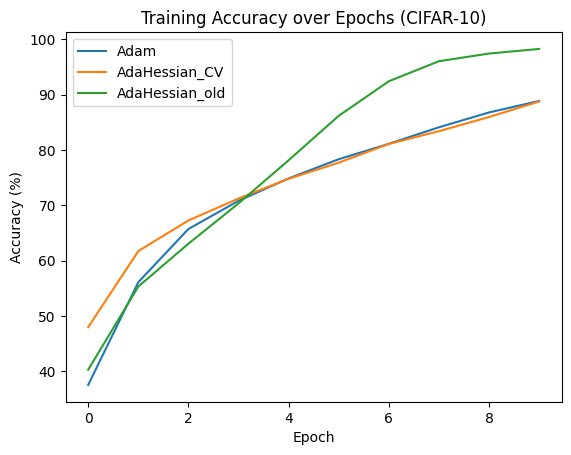


Run Times for Vision Task:
Adam: 119.00s
AdaHessian_CV: 474.71s
AdaHessian_old: 434.35s


In [ ]:

import torch
# Import necessary libraries
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

# For the NLP task
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math



# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print("Free memory before vision run")
get_free_memory()

#####################################
# Part 1: Vision Task (CIFAR-10)
#####################################

# Define transformations for the training and testing sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Load pre-trained ResNet-18 model
resnet18 = torchvision.models.resnet18(pretrained=False, num_classes=10)
resnet18 = resnet18.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Define the three optimizers
opt_1 = optim.Adam(resnet18.parameters(), lr=0.01)
opt_2 = AdaHessian(resnet18.parameters(), lr=0.01)
opt_3 = OldAdaHessian(resnet18.parameters(), lr=0.01)

optimizers = {'Adam': opt_1, 'AdaHessian_CV': opt_2, 'AdaHessian_old': opt_3}

# Function to train the model
def train(model, optimizer, epochs=5):
    model.train()
    train_acc = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        start_time = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward(create_graph=True)
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        end_time = time.time()
        accuracy = 100 * correct / total
        train_acc.append(accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, '
              f'Accuracy: {accuracy:.2f}%, Time: {end_time - start_time:.2f}s')
    return train_acc

# Function to evaluate the model
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Dictionary to store results
results = {}

# Train and evaluate the model with each optimizer
for opt_name, optimizer in optimizers.items():
    print(f'\nTraining with optimizer: {opt_name}')
    # Re-initialize the model weights to ensure fair comparison
    resnet18.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

    start_time = time.time()
    train_acc = train(resnet18, optimizer,epochs=10)
    val_acc = evaluate(resnet18)
    end_time = time.time()

    run_time = end_time - start_time
    results[opt_name] = {'train_acc': train_acc, 'val_acc': val_acc, 'run_time': run_time}
    print(f'Validation Accuracy: {val_acc:.2f}%')
    print(f'Total Training Time: {run_time:.2f}s')

# Plot the training accuracy for each optimizer
plt.figure()
for opt_name in optimizers.keys():
    plt.plot(results[opt_name]['train_acc'], label=opt_name)
plt.title('Training Accuracy over Epochs (CIFAR-10)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
del resnet18
torch.cuda.empty_cache()
for opt in optimizers.values():
  del opt

print("\nRun Times for Vision Task:")
for opt_name in optimizers.keys():
    print(f"{opt_name}: {results[opt_name]['run_time']:.2f}s")

In [ ]:
!pip install datasets

In [ ]:

#####################################
# Part 2: NLP Task (Text Generation)
#####################################

# For the NLP task, we'll create a simple dataset and a decoder-only transformer model.
# Since we are not using torchtext, we'll manually create a dataset.
#####################################
# Part 2: NLP Task (Text Generation)
#####################################

# For the NLP task, we'll use a real dataset from the Hugging Face datasets library.
# We'll use the WikiText-2 dataset and a decoder-only Transformer model.

# Import necessary libraries
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# Load the WikiText-2 dataset
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'])

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=['text'])

# Group the tokenized texts into chunks of a fixed size
block_size = 256

def group_texts(examples):
    """Concatenate texts and split into chunks of block_size."""
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples['input_ids'])
    # Drop the last chunk if it's smaller than block_size
    total_length = (total_length // block_size) * block_size
    # Split into chunks
    result = {
        k: [concatenated_examples[k][i:i + block_size]
            for i in range(0, total_length, block_size)]
        for k in concatenated_examples.keys()
    }
    return result

lm_datasets = tokenized_datasets.map(group_texts, batched=True)

# Create PyTorch datasets and dataloaders
train_dataset = lm_datasets['train']
val_dataset = lm_datasets['validation']

# Define a data collator
def collate_fn(examples):
    input_ids = torch.tensor([example['input_ids'] for example in examples], dtype=torch.long)
    labels = input_ids.clone()
    return input_ids, labels

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)

# Define the decoder-only transformer model
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=8, num_layers=2):
        super(DecoderOnlyTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        decoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, activation = nn.GELU())
        self.transformer_decoder = TransformerEncoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def generate_square_subsequent_mask(self, sz):
        """Generate a square mask for the sequence. Mask out subsequent positions."""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, tgt):
        tgt_seq_len = tgt.size(0)
        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len).to(device)

        embedded = self.embedding(tgt) * math.sqrt(self.d_model)
        #This is necessary because flash attention does not yet have a double backward implemented. Perhaps my next project?
        with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_math=True, enable_mem_efficient=False):
          output = self.transformer_decoder(embedded, mask = tgt_mask , is_causal=True)
        output = self.fc_out(output)
        return output

vocab_size = tokenizer.vocab_size

# Instantiate the model

# Loss function and optimizers
criterion_nlp = nn.CrossEntropyLoss()

lr = .001
opt_1 = optim.Adam
opt_2 = AdaHessian
opt_3 = OldAdaHessian
optimizers_nlp = {'Adam': opt_1, 'AdaHessian_CV': opt_2, 'AdaHessian_old': opt_3}

# Function to train the NLP model
def train_nlp(model, optimizer, epochs=5):
    model.train()
    train_loss = []
    for epoch in range(epochs):
        epoch_loss = 0
        start_time = time.time()
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.transpose(0, 1)  # Transformer expects sequence first
            targets = targets.transpose(0, 1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion_nlp(outputs.view(-1, vocab_size), targets.reshape(-1))
            loss.backward(create_graph=True)
            optimizer.step()

            epoch_loss += loss.item()

        end_time = time.time()
        avg_loss = epoch_loss / len(train_dataloader)
        train_loss.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Time: {end_time - start_time:.2f}s')

    del optimizer
    gc.collect
    torch.cuda.empty_cache()
    return train_loss

# Function to evaluate the NLP model
def evaluate_nlp(model):
    # For simplicity, we'll evaluate on the training data itself
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.transpose(0, 1)
            targets = targets.transpose(0, 1)

            outputs = model(inputs)
            loss = criterion_nlp(outputs.view(-1, vocab_size), targets.reshape(-1))
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

# Dictionary to store NLP results
results_nlp = {}

print("Free memory before training NLP")
get_free_memory()


# Train and evaluate the NLP model with each optimizer
for opt_name, optimizer in optimizers_nlp.items():
    print(f'\nTraining NLP model with optimizer: {opt_name}')
    # Re-initialize the model weights to ensure fair comparison
    model_nlp = DecoderOnlyTransformer(vocab_size).to(device)
    optimizer = optimizer(model_nlp.parameters(), lr=lr)

    start_time = time.time()
    train_loss = train_nlp(model_nlp, optimizer)
    val_loss = evaluate_nlp(model_nlp)
    end_time = time.time()

    run_time = end_time - start_time
    results_nlp[opt_name] = {'train_loss': train_loss, 'val_loss': val_loss, 'run_time': run_time}
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Total Training Time: {run_time:.2f}s')
    del model_nlp
    del optimizer
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

# Plot the training loss for each optimizer
plt.figure()
for opt_name in optimizers_nlp.keys():
    plt.plot(results_nlp[opt_name]['train_loss'], label=opt_name)
plt.title('Training Loss over Epochs (Text Generation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




print("\nRun Times for NLP Task:")
for opt_name in optimizers_nlp.keys():
    print(f"{opt_name}: {results_nlp[opt_name]['run_time']:.2f}s")